Cones in the shadow of retinal blood vessels
--------------------------------------------

Cones in the shadow of retinal blood vessels have altered spectral sensitivity functions due to prereceptoral filtering of incident light by hemoglobin. [Spitschan et al., (2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0124328) targeted these so-called 'penumbral' cones with silent substitution stimuli to elicit the [entopic percept of a purkinje tree](https://en.wikipedia.org/wiki/Entoptic_phenomenon) in the observer. Basically, they saw their own retinal blood vessels, like when you go to the opticians and they shine that bright light in your eye, or when you move a candle leftwards and rightwards before your eye in a dark room whilst holding your gaze still. 

The stimulation device used by [Spitschan et al., (2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0124328) had 56 narrowband primaries. We include a somewhat idealised version of the calibration spectra in *PySilSub*'s package data. 

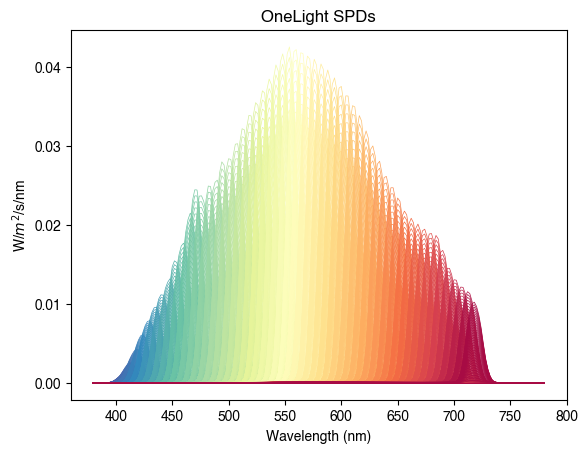

In [2]:
from pysilsub import problems


# Get the OneLight stimulation device from package data.
ssp = problems.SilentSubstitutionProblem.from_package_data('OneLight')
ssp.plot_calibration_spds(legend=False);

Now, to create action spectra for penumbral cones, we need an estimate of the retinal hemoglobin transmittance spectrum. This is easily obtained from `pysilsub.precep`, but to learn more about the theory behind the calculations, refer to [Spitschan et al., (2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0124328), then [read this page](https://omlc.org/spectra/hemoglobin/), and then [look at the code](https://github.com/PySilentSubstitution/pysilsub/blob/main/pysilsub/precep.py#L25).

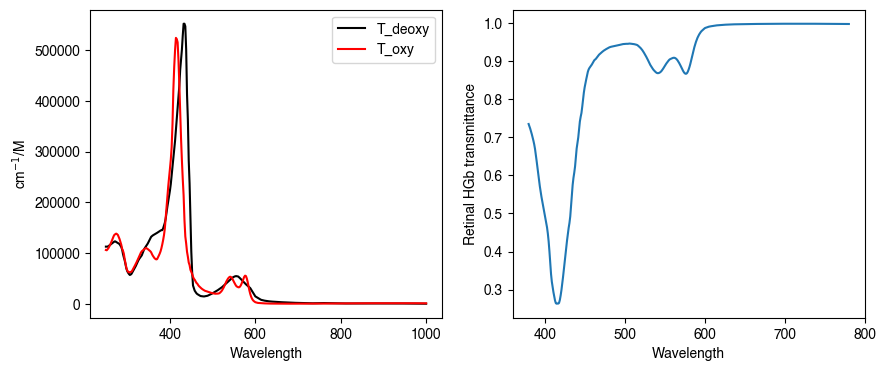

In [4]:
import matplotlib.pyplot as plt

from pysilsub.precep import get_retinal_hemoglobin_transmittance, get_hemoglobin_absorptances


# Get hemoglobin absorptances for display purposes. These
# are in molar extinction units, which I would probably know
# more about if I didn't drop chemistry at college.
hgb = get_hemoglobin_absorptances()

# Get retinal hemoglobin transmittance spectrum, assuming a vessel
# oxygenation fraction of 85% and thickness of 5 micrometers.
hgb_transmittance = get_retinal_hemoglobin_transmittance(
    wavelengths=(380, 781, 1),
    vessel_oxygenation_fraction=.85,
    vessel_overall_thickness_um=5
)

# Plot the absorptances and transmittance spectrum.
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
hgb.plot(ax=axs[0], color=['black', 'red'], ylabel='cm$^{-1}$/M')
hgb_transmittance.plot(ax=axs[1], ylabel='Retinal HGb transmittance');

Above we can see that the absorptance spectra of oxy- and deoxy-hemoglobin differ. For an overall transmittance spectrum of retinal hemoglobin, we must factor in the thickness and oxygenation fraction of retinal blood vessels. The parameters used above are taken from [Spitschan et al., (2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0124328), but ultimately there is some guesswork involved here.

Now that we have the transmittance spectrum for retinal hemoglobin we can create spectral sensitivity functions for penumbral cones. This is done by dividing the original action spectra for S-, M- and L-cones by the retinal HGb transmittance spectrum and then dividing each by the maximum value to renormalise.  

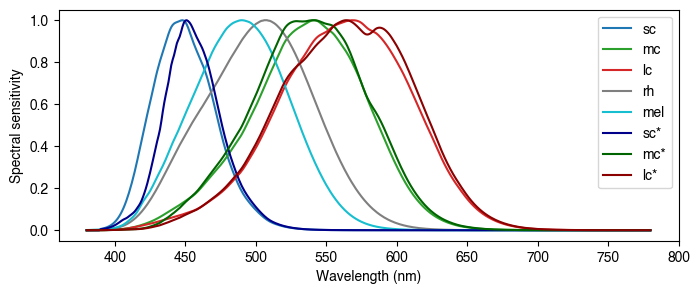

In [5]:
from pysilsub import observers

# Get the CIE 'standard observer'.
observer = observers.StandardColorimetricObserver()

# Multiply the spectral sensitivities (stored in a pandas DataFrame)
# by the HGb transmittance spectrum, divide by maximum, and assign a new label. 
penumbral_cones = observer.action_spectra[['sc', 'mc', 'lc']].mul(
    hgb_transmittance, axis=0)
penumbral_cones = penumbral_cones / penumbral_cones.max()
penumbral_cones.columns = [receptor + '*' for receptor in penumbral_cones.columns]

# Override list of photoreceptors and colors used for plotting.
# We add a '*' to denote the action spectra for penumbral cones.
observer.action_spectra = observer.action_spectra.join(penumbral_cones)
observer.photoreceptors = observer.action_spectra.columns.tolist()
observer.photoreceptor_colors = {
    "sc": "tab:blue",
    "mel": "tab:cyan",
    "rh": "tab:grey",
    "mc": "tab:green",
    "lc": "tab:red",
    "sc*": "darkblue",
    "mc*": "darkgreen",
    "lc*": "darkred"       
}

# Plot action spectra
observer.plot_action_spectra(figsize=(8, 3));

Great, we now have an `observer` class with additional action spectra for penumbral cones. In [Spitschan et al., (2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0124328), the purkinje tree percept was most evident when `mc*` and `lc*` photoreceptors were jointly stimulated at a modulation frequency of 16 Hz. 

Let's find the required device inputs for the background and modulation spectra.

In [6]:
# Interpolate the calibration spectra (they were originally sampled
# in 2 nm bins, but the action spectra here are in 1 nm bins).
ssp.calibration = ssp.calibration.reindex(
    range(380, 781, 1), axis=1).interpolate('linear', axis=1)
ssp.calibration_wavelengths = (380, 781, 1)

# Assign our custom observer with the penumbral cone action spectra.
ssp.observer = observer

# Define the problem. We will ignore rods and melanopsin, minimize 
# contrast on S-, M-, and L-cones, as well as penumbral S-cones. 
# We will target penumbral M- and L-cones with 1.3% contrast, 
# which is the maximum available in this example. The background 
# spectrum is all primaries at half-maximum.
ssp.ignore = ['rh', 'mel']
ssp.minimize = ['mc', 'lc', 'sc', 'sc*']
ssp.modulate = ['mc*', 'lc*']
ssp.target_contrast = .013
ssp.background = [.5] * ssp.nprimaries
ssp.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: OneLight
Observer: StandardColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh', 'mel']
Minimising: ['sc', 'mc', 'lc', 'sc*']
Modulating: ['mc*', 'lc*']
Target contrast: [ 0.013  0.013]
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]




Finally, a solution...

Primary inputs for background spectrum:
[128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]
Primary inputs for modulation spectrum:
[128, 129, 131, 137, 143, 145, 140, 128, 113, 102, 97, 100, 111, 129, 149, 171, 193, 216, 238, 250, 238, 192, 121, 52, 23, 44, 91, 118, 104, 69, 62, 104, 163, 196, 196, 179, 160, 145, 135, 129, 126, 125, 125, 125, 126, 126, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128]


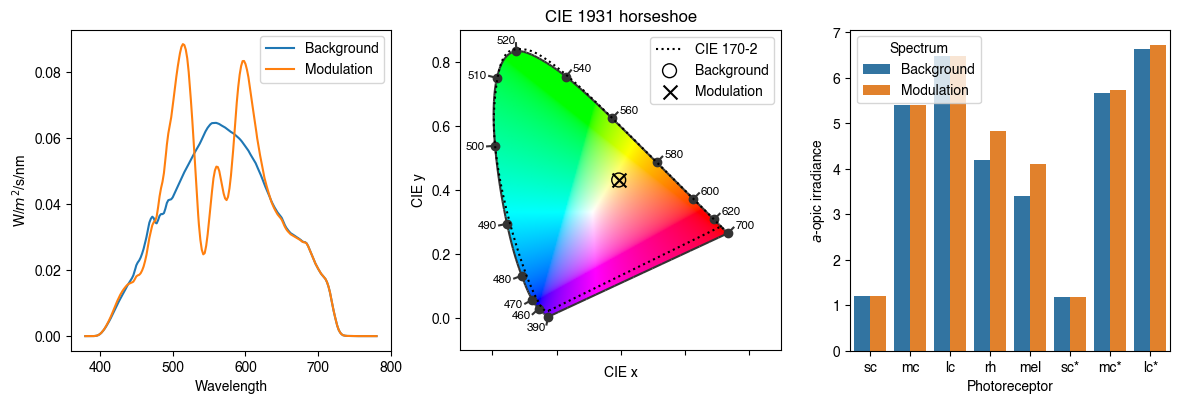

In [13]:
# Find solution with linear algebra.
solution = ssp.linalg_solve()
_ = ssp.plot_solution(solution)

# Display the native device inputs for the background and
# modulation spectra.
print('Primary inputs for background spectrum:')
print(ssp.w2s(ssp.background))
print('Primary inputs for modulation spectrum:')
print(ssp.w2s(solution))

Look closely at the solution depicted above. The `mc*` and `lc*` stimuli have slightly higher contrast for the modulation spectrum, whereas the other photoreceptors (barring rods and melanopsin, which we ignored) are the same. Alternating between these spectra at 16 Hz should cause the observer to experience the entopic Purkinje tree percept. I experienced this myself at the the Vision Sciences Society conference in 2015&mdash;it was a sight to behold!